# Part 3


1) Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

Term Frequency–Inverse Document Frequency (TF-IDF) measures how relevant a word is in a specific text. It is calculated by taking the product of TF (Term Frequency) and the IDF (Inverse Document Frequency). 

The TF measures how often a word appears in a text and the IDF measures how specific a word is to a text in question. This is done by comparing the number of text parts that contain that word with the total number of different texts.

Thus, by combining these 2 metrics, the TF-IDF score highlights words that are frequent in one text but rare in the rest of the collection. A high TF-IDF means that a work is highly descriptive of a certain text, because it appears in the text many times (high TF), but not so many in the other texts (high IDF).

Therefore, we can use TF-IDF to recognize the words that are truly intrinsic and, thus, characterize, a certain genre or community. In fact, artists that have the same words with higher values of TF-IDF probably share some type of relationship (same genre or other type of connection) and, thus, are more likely to belong to the same community. 

This way, we can use TF-IDF to better undertsand the words that are more relevant per genre, and, thus, identify it. Moreover, we also use it to identify relationships between artists that are crucial when we analyse our network structure and find the communities present. 


2) Calculate and visualize TF-IDF for the genres and communities.

In [180]:
#imports

import math
from collections import Counter
from pathlib import Path
import networkx as nx
import pickle as pkl
import random
import string
from collections import Counter, defaultdict
from pathlib import Path
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg

The objective of this part of the assigmnent is to calculate and visualize the TF-IDF for the genres and communities. To do this, we first need to compute the TF (Term Frequency) list for each one of them to make the TF-IDF calculations more straight-forward. These lists correspond to a record of how many times each word appears within a specific document, in our case, within a specific genre or community. To calculate this value, we used the txt version of each artist Wikipedia page, obtained through the Wikipedia API.   

In order to make these calculations easier to replicate, we elaborated a funtion for each one of these tasks: compute_tf_for_communities (elaborate the TF lists) and compute_tfidf (calculated TF-IDF), which can be seen below. Moreover, the function clean_tokenize was also elaborated to clean, tokenize and lemmatize each txt file, ensuring that only meaningful and sufficiently frequent words are retained. This is crucial to remove noise (such as punctuation, numbers, and stopwords) and to standardize the vocabulary before computing the TF lists and TF-IDF.

In [140]:
# initialize the list of common English stopwords and a lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_tokenize(text, rare_threshold=5):
    """
    Clean, tokenize, and lemmatize a text string.
    - Lowercase
    - Remove punctuation and numbers
    - Remove stopwords
    - Lemmatize words
    - Filter out rare words (freq < rare_threshold)

    Parameters:
    text: str
        Text being clean 
    rare_threshold: int
        Minimum number of times a word needs to appear in a text to be considered

    Returns
    tokens : list of str
        List of cleaned, lemmatized tokens that occur at least
        'rare_threshold' times in the text.
    """
    # lowercase
    text = text.lower()

    # remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", "", text)

    # tokenize (split on whitespace)
    tokens = text.split()

    # remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # lemmatize (reduce words to their base form)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # filter rare words
    freq = Counter(tokens)
    tokens = [t for t in tokens if freq[t] >= rare_threshold]

    return tokens


def compute_tf_for_communities(base_path, communities, out_folder, prefix="community", top_genres= None):
    """
    Compute term-frequency lists (TF) for a set of communities.

    Parameters  
    base_path : Path
        Folder with artist text files (.txt)
    communities : dict or list
        - If dict: {community_name: [artists]}
        - If list: [set(artists), set(artists), ...]
    out_folder : Path
        Output folder to store TF files
    prefix : str
        Prefix for naming files (e.g. 'primary', 'random', 'louvain')

     Returns
    genre_texts : dict
        Dictionary mapping each community name to a 'Counter' object containing
        the term frequencies of that community.
    """
    out_folder.mkdir(exist_ok=True)
    genre_texts = defaultdict(list)

    # normalize to dict form for convenience
    if isinstance(communities, list):
        communities = {f"{prefix}_{i+1}": list(c) for i, c in enumerate(communities)}

    # tokenize 
    # keep only the top genres 
    for name, artists in communities.items():
        if top_genres and name not in top_genres:
            continue
        combined_tokens = []
        for artist in artists:
            file_path = base_path / f"{artist.replace(' ', '_').lower()}.txt"
            text = file_path.read_text(encoding="utf-8")
            tokens = clean_tokenize(text)
            combined_tokens.extend(tokens)

        # compute and save TF for this community
        counts = Counter(combined_tokens)
        genre_texts[name] = counts

        # store TF lists
        if prefix== "louvain":
            out_file = out_folder / f"{name}_TF.txt"
        else:
            out_file = out_folder / f"{prefix}_{name}_TF.txt"
            
        with open(out_file, "w", encoding="utf-8") as f:
            for word, count in counts.most_common():
                f.write(f"{word} {count}\n")

    return genre_texts

In [172]:
def compute_tfidf(group_folder, label_type, top_n=10):
    """
    Compute TF-IDF for each group/community from the files containing the TF lists.

    Parameters
    group_folder : str or Path
        Path to the folder containing the TF lists files for each group or community.
    label_type : str
        Label indicating the type of grouping ("primary", "random", or "louvain"),
        used for formatting the printed output.
    top_n : int, optional
        Number of top words to display for each group based on TF-IDF score.
        Default is 10.

    Returns
    group_tfidf : dict
        Dictionary mapping each group name to a dictionary of {word: TF-IDF value}.
    idf : dict
        Dictionary of the computed inverse document frequency (IDF) values for all words.
    df : collections.Counter
        Counter object with document frequency counts for each word.
    """
    group_folder = Path(group_folder)
    group_tf = {}
    all_words = set()

    # load TF lists 
    for file in group_folder.glob("*_TF.txt"):
        name = file.stem  

        #  remove prefix (POR MAIS EFICIENTE)
        if name.lower().startswith("primary_"):
            prefix_removed = name[8:] 
        elif name.lower().startswith("random_"):
            prefix_removed = name[7:]  
        elif name.lower().startswith("louvain_"):
            prefix_removed = name[8:]
        elif name.lower().startswith("all_genres_"):
            prefix_removed = name[11:]

        # remove "_TF"
        prefix_removed = prefix_removed[:-3]

        # clean up spacing and capitalization
        clean_name = prefix_removed.strip().upper()

        # store words and frequencies
        counts = Counter()
        with open(file, "r", encoding="utf-8") as f:
            for line in f:
                    word, freq = line.strip().split()
                    freq = int(freq)
                    counts[word] = freq
                    all_words.add(word)
        group_tf[clean_name] = counts

    # compute DF 
    df = Counter()
    for word in all_words:
        df[word] = sum(1 for tf_counts in group_tf.values() if word in tf_counts)

    # compute IDF 
    N = len(group_tf)
    idf = {word: math.log((N + 1) / (df[word] + 1)) for word in all_words}

    # compute TF-IDF 
    group_tfidf = {}
    for group_name, tf_counts in group_tf.items():
        total_words = sum(tf_counts.values())
        tfidf = {word: (count / total_words) * idf[word] for word, count in tf_counts.items()}
        group_tfidf[group_name] = tfidf

    # print the results
    for group_name, tfidf_dict in group_tfidf.items():
        if "louvain" in label_type.lower():
            print(f"\n=== [{label_type.upper()}] Top {top_n} TF-IDF words for community {group_name} ===")
        else:
            print(f"\n=== [{label_type.upper()}] Top {top_n} TF-IDF words for genre: {group_name} ===")
        top_items = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for word, score in top_items:
            print(f"{word:<20s} {score:>10.6f}")

    return group_tfidf, idf, df


**PART2 COPY**

In [103]:
# Open dict with artist names and genres
with open("artist_genres.pkl", "rb") as file:
    artist_genres = pkl.load(file)
print(artist_genres)

{'disturbed (band)': ['heavy metal', 'alternative metal', 'hard rock', 'nu metal', '(early)'], 'breaking benjamin': ['hard rock', 'post-grunge', 'alternative metal', 'alternative rock'], 'mudvayne': ['alternative metal', 'nu metal', 'progressive metal', 'hard rock'], 'korn': ['nu metal', 'alternative metal'], 'deftones': ['alternative metal', 'art rock', 'shoegaze', 'nu metal', '(early)'], 'stone temple pilots': ['alternative rock', 'grunge', 'hard rock', 'alternative metal', 'psychedelic rock'], 'thousand foot krutch': ['christian rock', 'christian metal', 'heavy metal', 'hard rock', 'alternative rock', 'nu metal', 'rap metal'], 'linkin park': ['alternative rock', 'nu metal', 'rap rock', 'alternative metal', 'electronic rock', 'pop rock'], 'shinedown': ['hard rock', 'alternative metal', 'post-grunge', 'alternative rock', 'pop rock'], '10cc': ['art rock', 'art pop', 'progressive pop', 'soft rock', 'pop rock'], 'the hollies': ['rock', 'pop'], 'the beatles': ['rock', 'pop', 'beat', 'psyc

In [104]:
# Load the graph
print("Loading graph... \n")
G = nx.read_graphml("new_rock_artists.graphml")
print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges\n")

# Use only the undirected version of the graph
G = G.to_undirected()
print(f"Converted to undirected graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges\n")

# Get artist names from the artist_genres dictionary
artist_names = list(artist_genres.keys())
print(f"Number of artists with genre information: {len(artist_names)}\n")

# Select only nodes with a genre attribute
G = G.subgraph(artist_names)
print(f"Subgraph with genre attribute has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges\n")

# Visualize the nodes to check
G.nodes(data=True)

Loading graph... 

Loaded graph with 484 nodes and 8052 edges

Converted to undirected graph with 484 nodes and 6537 edges

Number of artists with genre information: 343

Subgraph with genre attribute has 343 nodes and 4382 edges



NodeDataView({'disturbed (band)': {'length_of_content': 10685}, 'breaking benjamin': {'length_of_content': 15060}, 'mudvayne': {'length_of_content': 7206}, 'korn': {'length_of_content': 26668}, 'deftones': {'length_of_content': 18978}, 'stone temple pilots': {'length_of_content': 9523}, 'thousand foot krutch': {'length_of_content': 6342}, 'linkin park': {'length_of_content': 34784}, 'shinedown': {'length_of_content': 11585}, '10cc': {'length_of_content': 10464}, 'the hollies': {'length_of_content': 6061}, 'the beatles': {'length_of_content': 32613}, 'frank zappa': {'length_of_content': 31101}, 'queen (band)': {'length_of_content': 42039}, 'george harrison': {'length_of_content': 24091}, 'asia (band)': {'length_of_content': 9029}, 'duran duran': {'length_of_content': 18336}, 'peter gabriel': {'length_of_content': 18820}, 'the clash': {'length_of_content': 14276}, 'ramones': {'length_of_content': 17267}, 'paul mccartney': {'length_of_content': 38193}, 'ringo starr': {'length_of_content':

As in Part 2 we will compare the attribution of the primary genre and the random one with the communitues generated by the Louvain method. 

In [105]:
# --- Part 2: Community Detection based on Genres ---
# Two different partitions are created based on the genres of the artists:
# 1. A partition where each artist is assigned to their primary genre (the first genre in their list).
# 2. A partition where each artist is randomly assigned to one of their genres.
# 3. A partition using Louvain method for community detection.

# 1. Creating a partition based on the primary genre
primary_genre_partition = {}
for artist, genres in artist_genres.items():
        primary_genre = genres[0]  # Take the first genre as primary
        primary_genre_partition[artist] = primary_genre

# 2. Creating a second partition, where we randomly assign on of the artist genres to each artist
random_genre_partition = {}
for artist, genres in artist_genres.items():
        random_genre = random.choice(genres)  # Randomly select one genre
        random_genre_partition[artist] = random_genre

# Building the communities dictionary based on the primary genre partition
primary_genre_communities = {}
for artist, genre in primary_genre_partition.items():
    if genre not in primary_genre_communities:
        primary_genre_communities[genre] = []
    primary_genre_communities[genre].append(artist)
print(f"Total communities formed based on primary genre: {len(primary_genre_communities)}")

# Building the communities dictionary based on the random genre partition
random_genre_communities = {}
for artist, genre in random_genre_partition.items():
    if genre not in random_genre_communities:
        random_genre_communities[genre] = []
    random_genre_communities[genre].append(artist)
print(f"Total communities formed based on random genre: {len(random_genre_communities)}")

# Building the Louvain partition using NetworkX's built-in function
louvain_communities = nx.community.louvain_communities(G)
print(f"Total communities formed using Louvain method: {len(louvain_communities)}\n")

print("Calculating modularity for each partition...\n")

# Print the beginning of each community (first 5 artists per genre)
for genre, artists in list(primary_genre_communities.items())[:3]:
    print(f"Communities based on primary genre: \n {genre} (n = {len(artists)}): {artists[:5]}")
print("---")
for genre, artists in list(random_genre_communities.items())[:3]:
    print(f"Communities based on random genre: \n {genre} (n = {len(artists)}): {artists[:5]}")
print("---")
for i, community in enumerate(louvain_communities[:3]):
    print(f"Louvain Community {i+1} (n = {len(community)}): {list(community)[:5]}")
print("---")

Total communities formed based on primary genre: 70
Total communities formed based on random genre: 101
Total communities formed using Louvain method: 4

Calculating modularity for each partition...

Communities based on primary genre: 
 heavy metal (n = 11): ['disturbed (band)', 'ozzy osbourne', 'accept (band)', 'judas priest', 'metallica']
Communities based on primary genre: 
 hard rock (n = 31): ['breaking benjamin', 'shinedown', 'alter bridge', 'kiss (band)', 'led zeppelin']
Communities based on primary genre: 
 alternative metal (n = 12): ['mudvayne', 'deftones', 'staind', 'faith no more', 'tool (band)']
---
Communities based on random genre: 
 alternative metal (n = 13): ['disturbed (band)', 'stone temple pilots', 'alter bridge', 'staind', 'system of a down']
Communities based on random genre: 
 post-grunge (n = 6): ['breaking benjamin', 'shinedown', 'daughtry (band)', 'hinder', 'goo goo dolls']
Communities based on random genre: 
 hard rock (n = 28): ['mudvayne', '3 doors down',

Now that everything is set up, we will compute the TF-IDF for the genres and communities. To do this, we will start by elaborating the TF lists considering the 3 possibilities for aggregating nodes (1 per each).

The 10 most common genres will be used according to part 2.

In [ ]:
# This part is from part 2 as well 

genre_counter = Counter()
for genres in artist_genres.values():
    genre_counter.update(genres)



**STOP PART2 COPY**

In order to compute reliable values for the TF-IDF score, we will use the 15 most common genres.

In [ ]:
# Select top 15 genres
top_genres = [g for g, _ in genre_counter.most_common(15)]

We will now use the described functions to compute TF lists and the TF-IDF, using the formulas mentioned in exercise 1 of the this part of the assigment.

In accordance with Part 2, we will also consider three ways to aggrupate the artists according to genre or community: the first genre that appears associated with them (primary genre), a random genre and the communities obtained with the Louvain method.
This way, we can evaluate the impact of considering each type of genre attribution in the TF-IDF obtained. 


In [108]:
# Path to the folder containing the text from each Wikipedia page 
base_path = Path("artists")

In [160]:
# TF lists for the Louvain communities
tf_louvain = compute_tf_for_communities(base_path, louvain_communities, Path("Louvain_TF"), prefix="louvain", top_genres= None)

In [161]:
# TF lists considering the primary genre
tf_primary = compute_tf_for_communities(base_path, primary_genre_communities, Path("Primary_TF"), prefix="primary", top_genres= top_genres)

In [162]:
# TF lists considering a random genre
tf_random = compute_tf_for_communities(base_path, random_genre_communities, Path("Random_TF"), prefix="random", top_genres= top_genres)

Now that we have obtained and saved the TF lists for each genre/community, we can compute the TF-IDF associated with each one of them. Note that each printed Dataframe contains the genre/community divison being used in each case (for example [PRIMARY GENRE]) and the 10 most significant words (higher TF-IDF) for each genre in descending order. The analysis of the results obtained will be done below using bar plots to better visualize the results.

In [163]:
# TF-IDF considering the primary genre 
tfidf_primary, idf_primary, df_primary = compute_tfidf("Primary_TF", label_type="primary genre")


=== [PRIMARY GENRE] Top 10 TF-IDF words for genre: ALTERNATIVE METAL ===
cornell                0.014653
evanescence            0.007799
deftones               0.006982
tool                   0.006980
primus                 0.005698
pool                   0.005538
godsmack               0.004857
staind                 0.004506
system                 0.004292
claypool               0.004289

=== [PRIMARY GENRE] Top 10 TF-IDF words for genre: ALTERNATIVE ROCK ===
pilot                  0.004935
morrissey              0.004411
chemical               0.004047
coldplay               0.003912
fighter                0.003656
romance                0.003521
rem                    0.002927
weezer                 0.002748
twenty                 0.002715
linkin                 0.002661

=== [PRIMARY GENRE] Top 10 TF-IDF words for genre: BLUES ROCK ===
zz                     0.033669
stripe                 0.017458
jack                   0.015230
white                  0.014627
titlejack         

In [164]:
# TF-IDF considering a random genre 
tfidf_random, idf_random, df_random = compute_tfidf("Random_TF", label_type="random genre")


=== [RANDOM GENRE] Top 10 TF-IDF words for genre: (EARLY) ===
sevenfold              0.015068
beastie                0.014160
incubus                0.014011
avenged                0.012596
deftones               0.012349
distortion             0.011773
fray                   0.010126
cab                    0.009221
cutie                  0.008488
ness                   0.007057

=== [RANDOM GENRE] Top 10 TF-IDF words for genre: ALTERNATIVE METAL ===
bridge                 0.009835
grace                  0.008617
alter                  0.008150
pilot                  0.007047
disturbed              0.006985
staind                 0.006318
system                 0.006131
temple                 0.005365
saliva                 0.005024
rage                   0.004932

=== [RANDOM GENRE] Top 10 TF-IDF words for genre: ALTERNATIVE ROCK ===
cornell                0.009174
pumpkin                0.006418
dragon                 0.006223
rem                    0.006190
radiohead              0

In [165]:
# TF-IDF considering the Louvain communities
tfidf_louvain, idf_louvain, df_louvain= compute_tfidf("Louvain_TF", label_type="louvain community")


=== [LOUVAIN COMMUNITY] Top 10 TF-IDF words for community 1 ===
cornell                0.001445
sabbath                0.001376
osbourne               0.001128
slipknot               0.001087
slayer                 0.001076
korn                   0.001014
megadeth               0.000992
bizkit                 0.000963
linkin                 0.000926
soundgarden            0.000923

=== [LOUVAIN COMMUNITY] Top 10 TF-IDF words for community 2 ===
nugent                 0.001885
aerosmith              0.001675
leppard                0.001552
coverdale              0.001417
whitesnake             0.001126
lizzy                  0.001109
jovi                   0.000968
slade                  0.000834
zz                     0.000832
simmons                0.000795

=== [LOUVAIN COMMUNITY] Top 10 TF-IDF words for community 3 ===
dylan                  0.001536
clapton                0.001505
presley                0.001365
mccartney              0.001201
gabriel                0.001178
lenno

As mentioned before, in order to better understand the most significant words found for each genre/community, a bar plot was computed. This plot has on the vertical axis the 10 more significant words and on the vertical axis the TF-IDF score associated with them. Their analysis was conducted below.

To make the plots easier to reproduce we elaborate the function plot_tfidf_bars, which takes as argument the tf-idf dictionary for the genres/communities in question and produces the bar plot for the top_n (another function argument) most significant words. The function also has an argument that allows us to save or show the plot obtained. The bar plot was produced using the Seaborn and Matplotlib libraries, which allow clear visualization of the top TF-IDF words for each group through multi-panel bar charts.

In [202]:
def plot_tfidf_bars(group_tfidf, label_type, top_n=10, save_path=None, top_genres=None):
    """
    Create bar plots showing the top TF-IDF words for selected groups or communities.

    Parameters
    group_tfidf : dict
        Dictionary mapping each group name to a dictionary of words and
        their corresponding TF-IDF values.
        
    label_type : str
        Type of community/genre attribution used in the analysis.
        Used in the figure title.
    top_n : int, optional
        Number of top words to display for each group. Default is 10.
    save_path : str or Path, optional
        File path to save the resulting figure. If not provided, the plot is shown
        interactively instead.
    top_genres : list of str, optional
        List of genre or community names to include in the plots.
        If None, all groups in 'group_tfidf' are plotted.

    Returns
    None
    """
    # --- Filter to selected genres if specified ---
    if top_genres:
        # Normalize both sides to lowercase for flexible matching
        selected = {k: v for k, v in group_tfidf.items() if k.lower() in [g.lower() for g in top_genres]}
    else:
        selected = group_tfidf

    if not selected:
        print("⚠️ No matching genres found in group_tfidf for the given top_genres list.")
        return

    # --- Prepare plotting data ---
    rows = []
    for group, scores in selected.items():
        top_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for word, score in top_items:
            rows.append((group, word, score))
    df = pd.DataFrame(rows, columns=["Group", "Word", "TF-IDF"])

    # --- Determine grid layout ---
    n_groups = df["Group"].nunique()
    n_cols = min(4, n_groups)
    n_rows = math.ceil(n_groups / n_cols)

    # --- Create subplots grid ---
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows), sharey=False)
    axes = axes.flatten() if n_groups > 1 else [axes]

    # --- Plot each group ---
    palette = sns.color_palette("Set2", n_groups)
    for ax, (group, subdf), color in zip(axes, df.groupby("Group"), palette):
        sns.barplot(
            data=subdf,
            y="Word",
            x="TF-IDF",
            ax=ax,
            color=color
        )
        ax.set_title(group, fontsize=13, weight="bold")
        ax.set_xlabel("TF-IDF score", fontsize=11)
        ax.set_ylabel("")
        ax.invert_yaxis()
        sns.despine(ax=ax)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.xaxis.get_offset_text().set_fontsize(10)

    # Hide unused axes 
    for j in range(len(df["Group"].unique()), len(axes)):
        axes[j].set_visible(False)

    # Figure title and layout 
    fig.suptitle(f"Top {top_n} TF-IDF Words considering {label_type.title()}",
                 fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save or show 
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()


To better visualize the TF-IDF scores obtained we will plot only the 7 most common genres, as those were the ones included in Part 2 analysis as well.

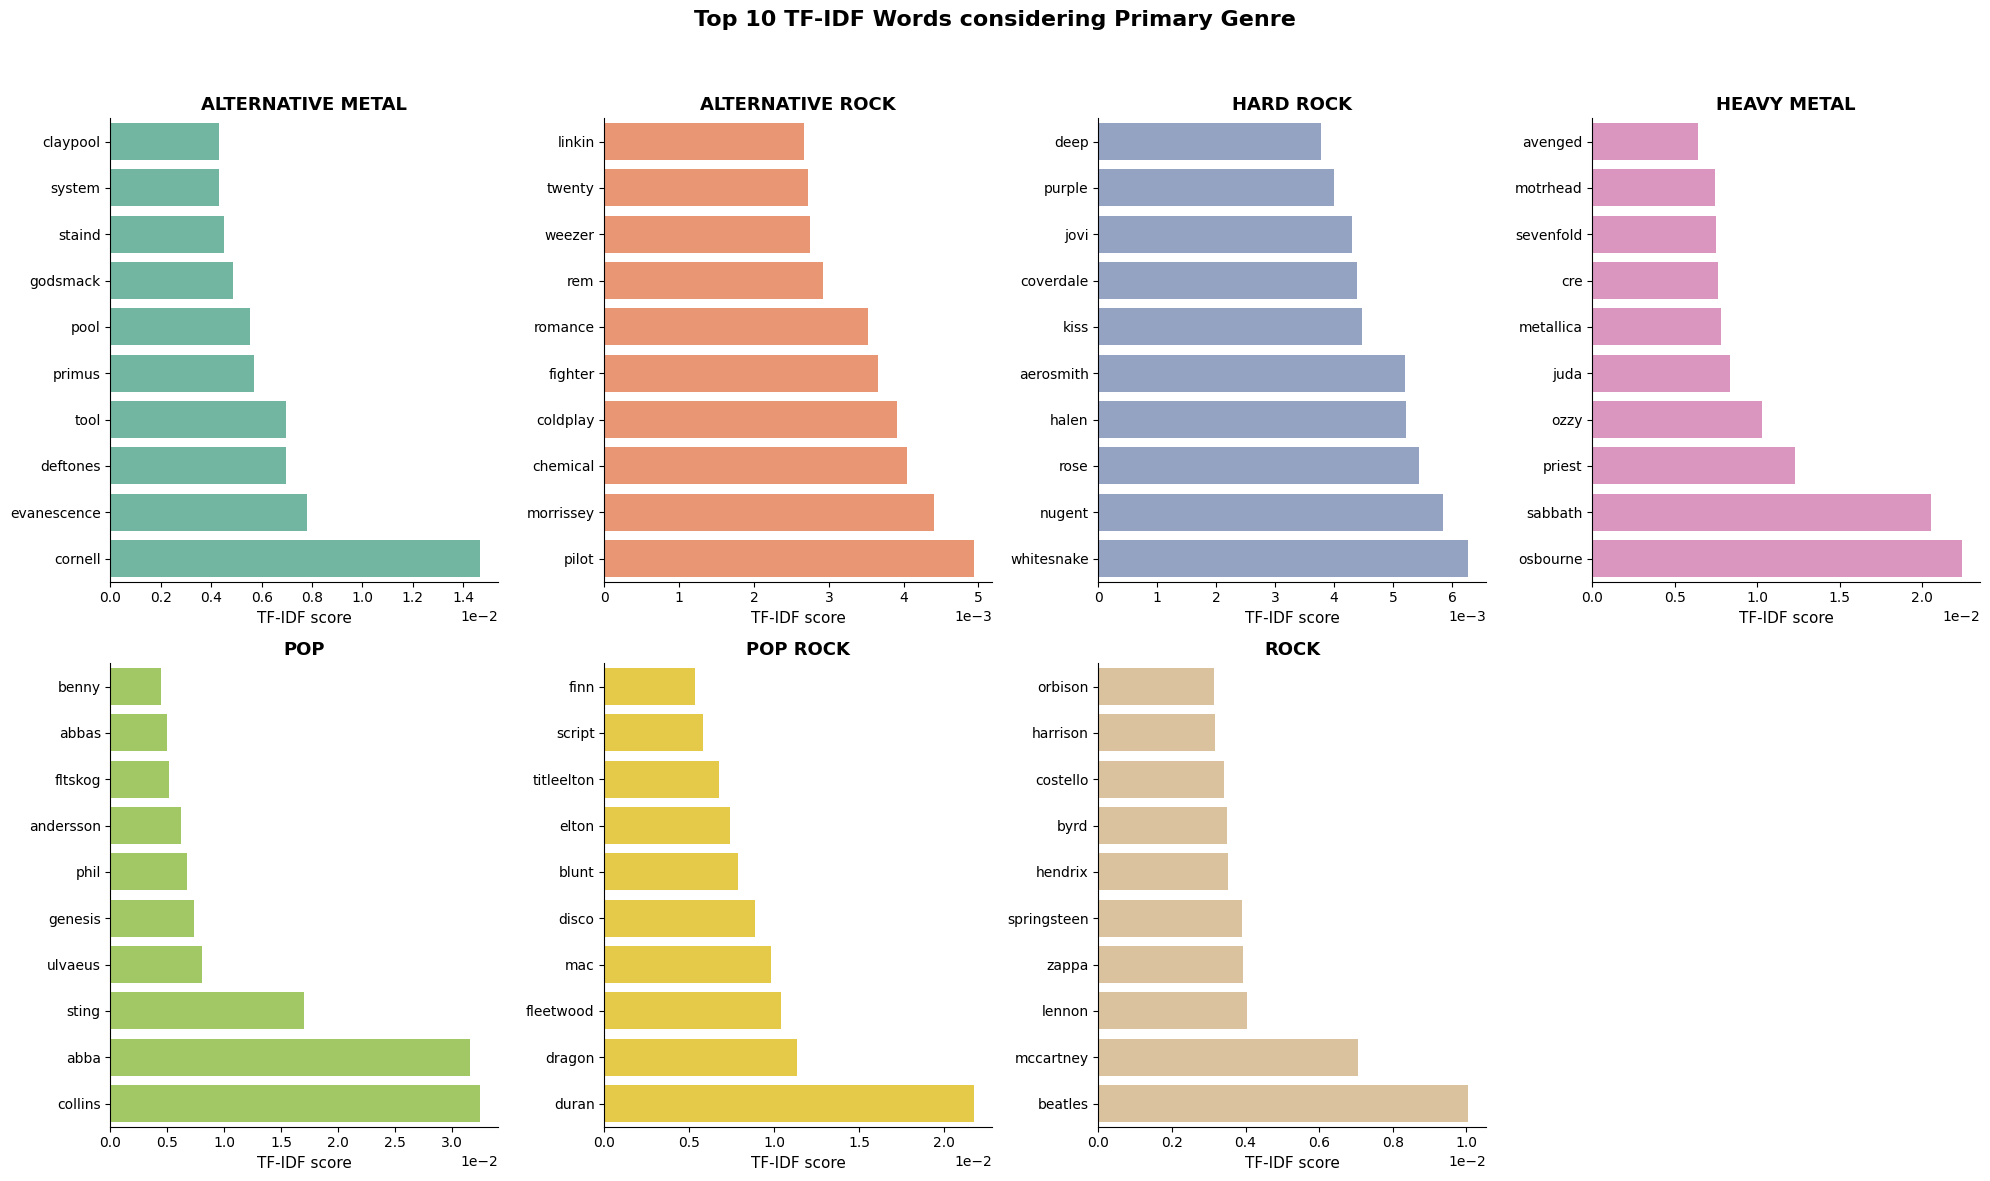

In [203]:
# Select top 7 genres to include in the plot
top_genres_plot = [g for g, _ in genre_counter.most_common(7)]

plot_tfidf_bars(tfidf_primary, label_type="Primary Genre", save_path="plots/tfidf_primary.png", top_genres= top_genres_plot)

This figure shows the 10 most relevant words (higher TF-IDF) for each genre, considering that the each artist belongs to the first genre associated with it (Primary Genre).

We can observe that most significant words for each genre are usually associated with major bands belonging to the genre in question. For example, Beatles is the most relevant word in the rock genre, since they are one of the most influential bands associated with it. The same can be seen with ABBA in the pop genre, Duran (from the band Duran Duran) in pop rock and Evanescence in alternative metal. Moreover, we can also see that main singers associated with the genres are also very relevant, such as Collins and Phil (singer and drummer Phil Collins) in pop and Cornell (singer Chris Cornell from the band Soundgarden) in the alternative metal genre. 

Therefore, we can conclude that the singers and bands that are very influential in each genre are the words that identify it (words with the higher TF-IDF). This was expected since it makes sense that these are the words most mentioned in the Wikipedia pages associated with the genre in question.

Additionally, the figure reveals that genres with a more defined identity, such as Heavy Metal or Alternative Metal, display more distinctive vocabularies characterized by specific and unique terms (Osbourne, Sabbath, Deftones, Tool), which hardly appear in other genres. On the other hand, more hybrid categories like Pop Rock or Alternative Rock show a more diverse set of words and slightly lower TF-IDF magnitudes, reflecting the overlap between subgenres and the wider range of the artists included. The Pop genre, in turn, shows a very good internal coherence, dominated by ABBA-related names (Abba, Benny, Andersson), confirming the strong association between this group and the textual identity of the genre. Meanwhile, Rock has a wider historical spectrum, mixing references to classic icons such as Beatles, Hendrix, and Springsteen, illustrating its role as a broad and foundational category within which many subgenres originate. 

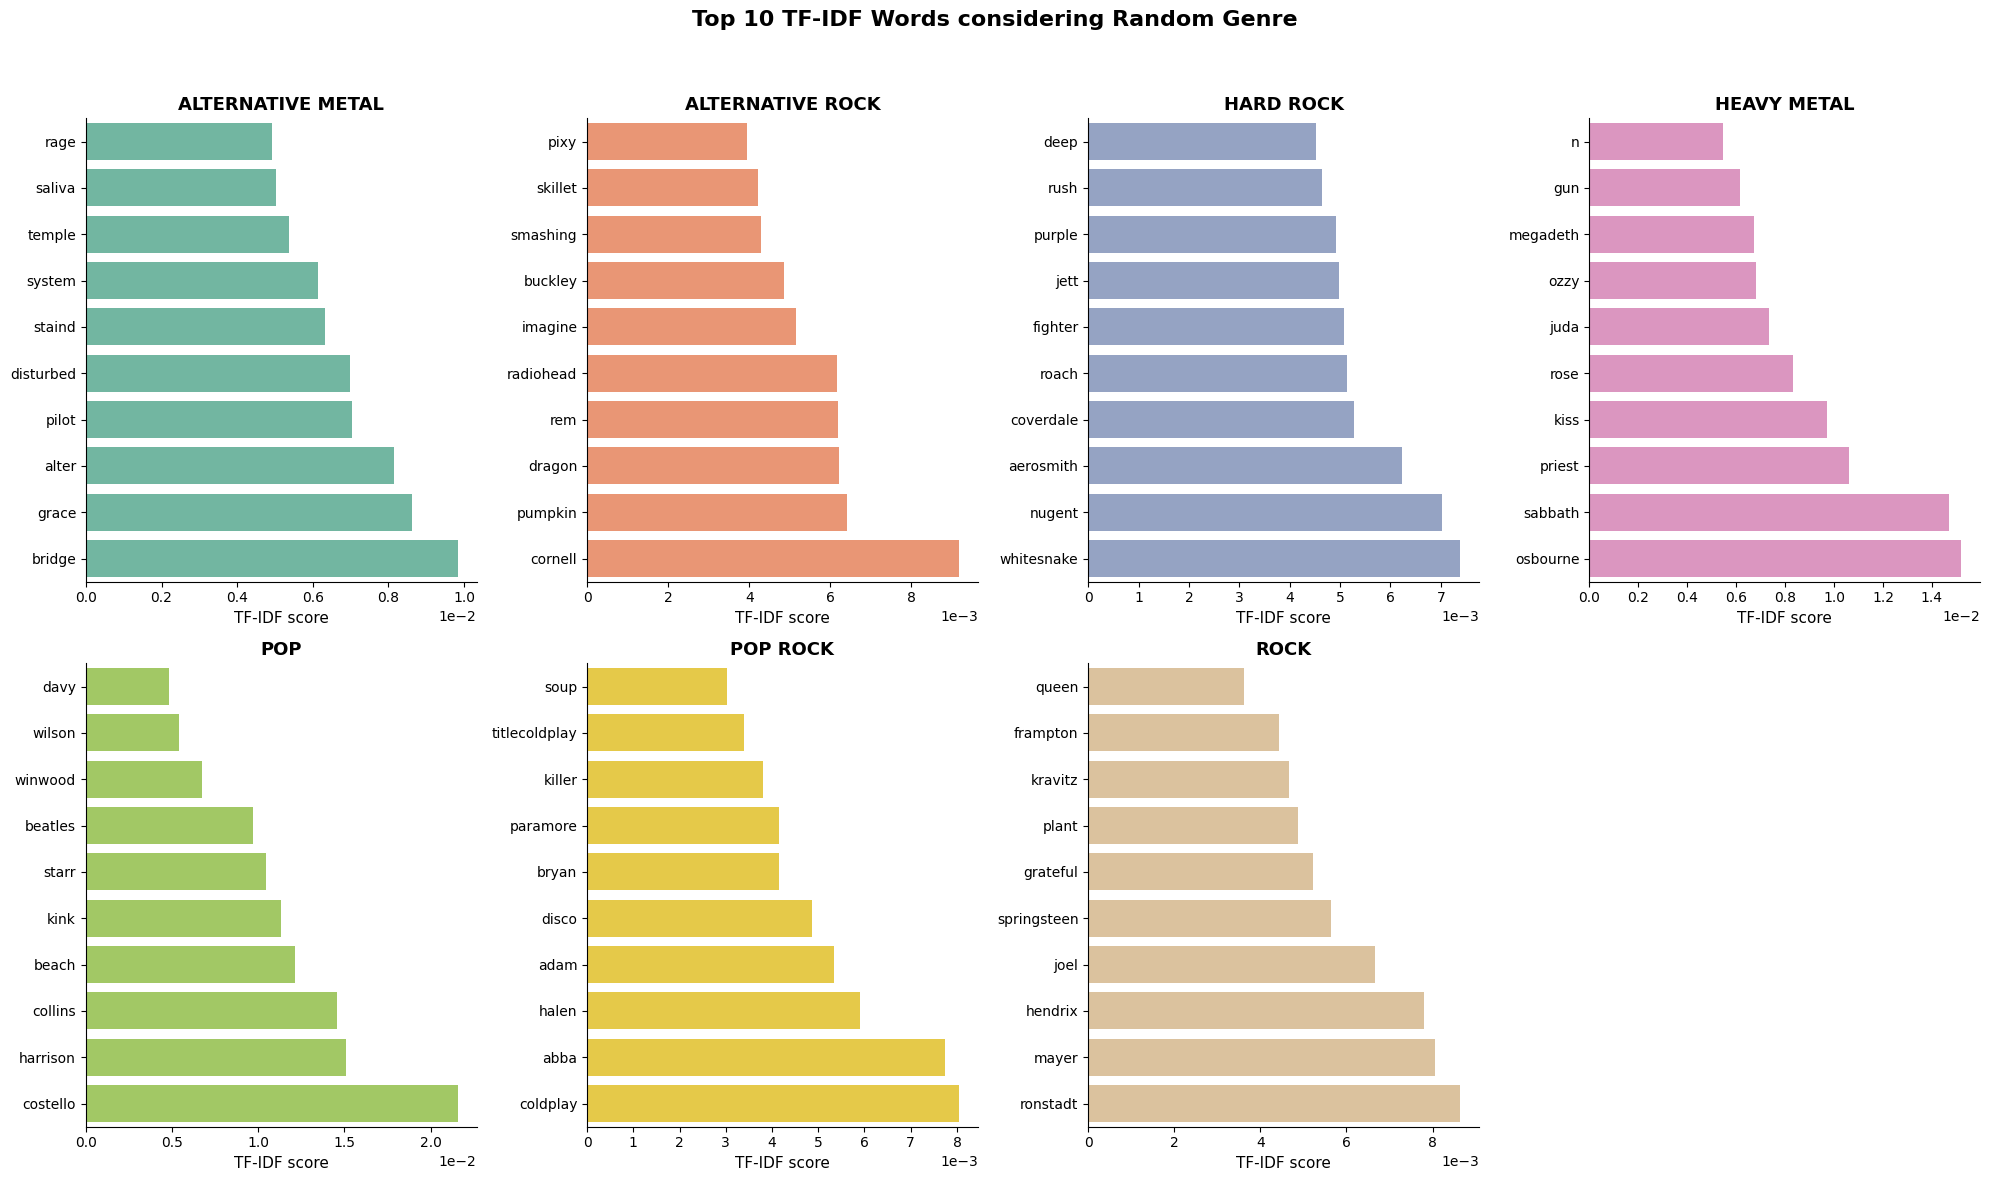

In [205]:
plot_tfidf_bars(tfidf_random, label_type="Random Genre", save_path="plots/tfidf_random.png", top_genres= top_genres_plot)

This figure shows the most relevant words for each genre, considering that the each artist belongs to a random genre associated with it (Random Genre).

We can reach similar conclusions as before. We observe that the most significant words for each genre continue to be bands and singers associated with it (for example, Coldplay for pop rock). We can also see that some bands and singers are present in both Figures associated with the same genres, for example, Aerosmith in hard rock, and others differ, such as Imagine and Dragons (from the band Imagine Dragons) that are present in this Figure in the alternative rock genre but not on the anterior one. 
There are also some words that, in this Figure, are very significant for a genre, but on the previous one are very relevant to another. For example, the word Cornell is very significant in the alternative rock genre in this Figure, however, in the previous one is the most significant word in the alternative metal genre. This highlights the fact that, since some genres are very similar, some artists can be associated with multiple different genres resulting in them being significant for different genres depending on the critearia utilized in the genre attribution.

Overall, this approach maintains the general thematic consistency observed before, but introduces greater variability in the specific associations. The TF-IDF results become slightly less stable, especially for genres that naturally overlap, such as Alternative Rock and Pop Rock. This variation demonstrates how sensitive the textual characterization of musical genres can be to small changes in how artists are classified, emphasizing the importance of consistent genre assignment to obtain a good linguistic differentiation.


Saved TF-IDF bar plot to: plots/tfidf_louvain.png


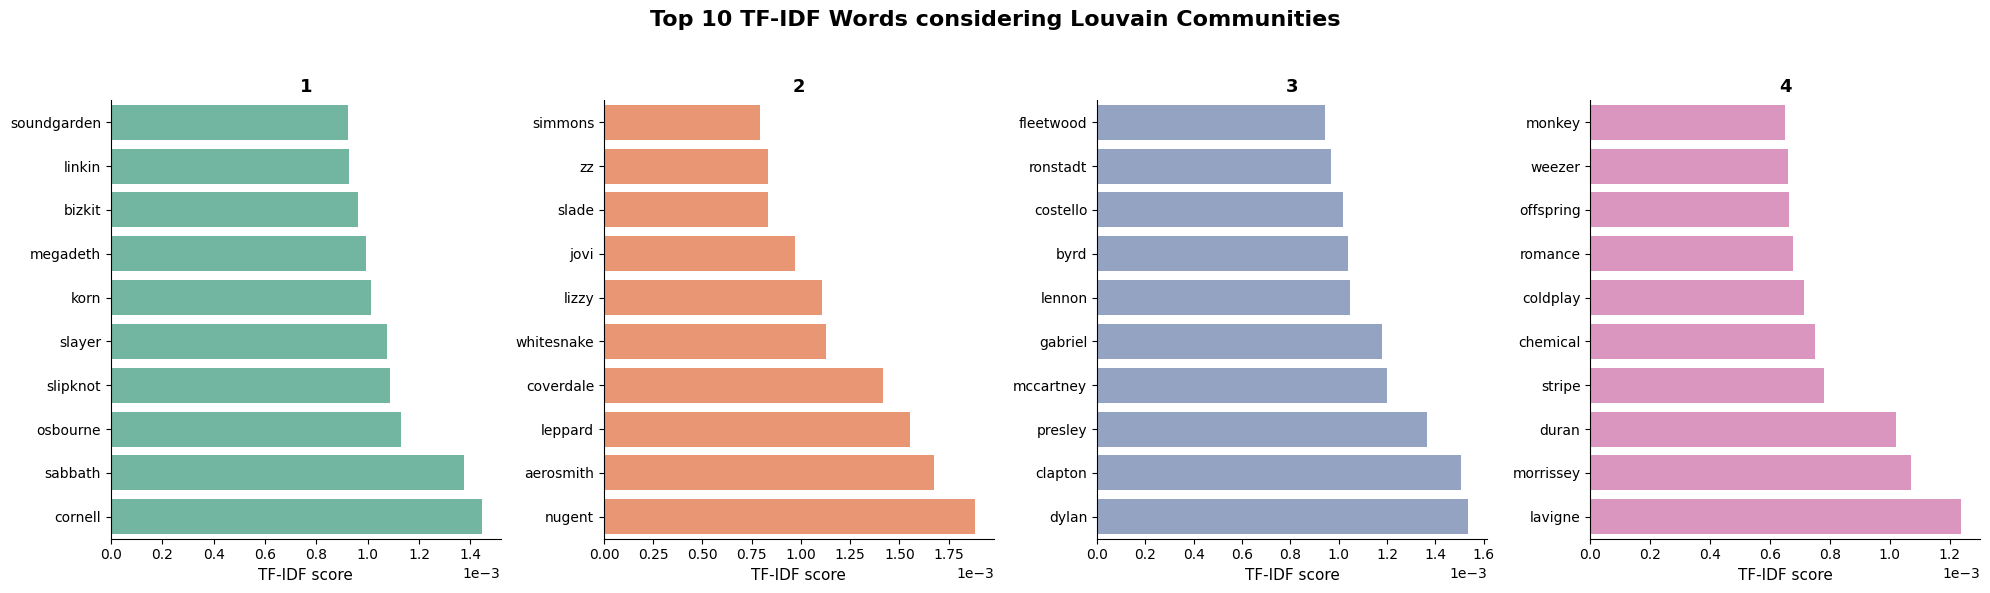

In [119]:
plot_tfidf_bars(tfidf_louvain, label_type="Louvain Communities", save_path="plots/tfidf_louvain.png")

This figure shows the most relevant words for each community, considering that the each artist belongs to a community obtained with the Louvain method. 

By comparing this Figure with the anterior ones, we can observe that Community 1 more significant words are also present in heavy and alternative metal and rock genres (this can be seen in the words Cornell, Sabbath and Osbourne, for example) in the primary and random genre analysis. Community 2 words are associated with the hard rock genre, as can be seen by the words Aerosmith and Nugent for example, that are associated with this genre in the anterior figures. Community 4 can be associated with pop rock, since the words Duran, chemical and Coldplay that are significant in this community are also very relevant to that genre. Community 3 has a weaker relationship with genre, since the top 3 words of this community do not show up in any of the anterior genre plots. However, the words Mccartney, Ronstad and Fleetwood are present in the rock (Primary Genre Figure) and pop (Random Genre Figure) genres.

Thus, we can conclude that there is a relationship between communities and the genres, since some of the main words of certain genres overlap with the ones from certain communities. However, the overlap is not perfect. There are some words very important in the Communities (for example the word Lavigne in Community 4) that are not associated with any genre. This supports the claim that the comunities, more than representing a genre or a collection of similar ones, capture the internal structure of the network and the real assocations between artists. Moreover, communities sometimes unite artists that belong to multiple genres, highlighting the fluid boundaries of musical genres and the the fact that the majority of music styles are interconnected.

3) Use the matrix D
 (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.
 

In this part of the assigment, we will use the importance of each word in each genre/community given by the TF-IDF score to compute the wordclouds for each genre/community. The TF-IDF score represents the weight given to each word that will translate in the wordcloud to the size of the word. 
We elaborated the create_wordcloud function that receives as input a dictionary containing the TF-IDF values associated with the words, computes the wordcloud using the WordCloud module and saves it to a folder with a path received as argument out_folder. 

In [ ]:
def create_wordclouds(group_tfidf, out_folder, max_words=100):
    """
    Create and save word clouds for each community/group based on TF-IDF scores.

    Parameters
    group_tfidf : dict
        Dict from compute_tfidf(): {group_name: {word: tfidf_value}}
    out_folder : str or Path
        Folder where the PNG files will be saved
    label_type : str
        Label type to show in titles (e.g. 'primary genre', 'louvain community')
    max_words : int
        Maximum number of words in each word cloud

    Returns
    None
    """
    out_folder = Path(out_folder)
    out_folder.mkdir(exist_ok=True)

    for group_name, tfidf_scores in group_tfidf.items():
        if not tfidf_scores:
            continue

        # Normalize values (to help visual scaling)
        max_val = max(tfidf_scores.values())
        freqs = {word: score / max_val for word, score in tfidf_scores.items()}

        # Create world-cloud 
        wc = WordCloud(
            width=1200,
            height=800,
            background_color="white",
            max_words=max_words,
            colormap="viridis",
            random_state=42
        ).generate_from_frequencies(freqs)

        # Save figure
        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for '{group_name}'", fontsize=14)
        out_path = out_folder / f"{group_name}_wordcloud.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.close()



In this part of the assigment, we will consider that each artist belongs to all genres that are associated with it, as was done in Part 2, to achieve coherent results and conclusions when comparing them. Thus, we need to compute the TF lists and again. Since TF-IDF is a relative quantity (how important a word is to a certain document compared to the words of other documents), we also need to compute it again. 

In [222]:
print(louvain_communities[0])
print(louvain_communities[1])
print(louvain_communities[2])
print(louvain_communities[3])


{'theory of a deadman', 'marilyn manson', 'soundgarden', '3 doors down', 'evanescence', 'bring me the horizon', 'breaking benjamin', 'slipknot (band)', 'ozzy osbourne', 'faith no more', 'killswitch engage', 'alice in chains', 'tool (band)', 'halestorm', 'mudvayne', 'hinder', 'deftones', 'stone temple pilots', 'pop evil', 'avenged sevenfold', 'stone sour', 'rob zombie', 'saliva (band)', 'black sabbath', 'audioslave', 'korn', 'three days grace', 'godsmack', 'daughtry (band)', 'nickelback', 'incubus (band)', 'the smashing pumpkins', 'bullet for my valentine', 'chris cornell', 'volbeat', 'flyleaf (band)', 'judas priest', 'system of a down', 'p.o.d.', 'metallica', 'rammstein', 'lamb of god (band)', 'primus (band)', 'sepultura', 'lacuna coil', 'chevelle (band)', 'motörhead', 'accept (band)', 'rush (band)', 'linkin park', 'dio (band)', 'pantera', 'led zeppelin', 'disturbed (band)', 'drowning pool', 'shinedown', 'seether', 'papa roach', 'creed (band)', 'fuel (band)', 'thirty seconds to mars', 

In [ ]:
## COPIADO PARTE 2 ####
# Map genres to artists 
genre_to_artists = {}
for artist, genres in artist_genres.items():
    if not genres:
        continue
    for g in genres:
        genre_to_artists.setdefault(g, set()).add(artist)

In [207]:
tf_all_genres = compute_tf_for_communities(base_path, genre_to_artists , Path("All_genres_TF"), prefix="all_genres", top_genres= top_genres)

tfidf_all_genres, idf_all_genres, df_all_genres = compute_tfidf("All_genres_TF", label_type="all genres")


=== [ALL GENRES] Top 10 TF-IDF words for genre: (EARLY) ===
beastie                0.002942
leppard                0.002759
lizzy                  0.002583
anselmo                0.002334
evanescence            0.002284
def                    0.002214
deftones               0.002152
goo                    0.002131
horizon                0.002000
incubus                0.001966

=== [ALL GENRES] Top 10 TF-IDF words for genre: ALTERNATIVE METAL ===
cornell                0.002618
sepultura              0.001996
roach                  0.001802
slipknot               0.001708
soundgarden            0.001588
marilyn                0.001499
tool                   0.001469
manson                 0.001429
korn                   0.001392
sum                    0.001362

=== [ALL GENRES] Top 10 TF-IDF words for genre: ALTERNATIVE ROCK ===
morrissey              0.001922
lavigne                0.001841
chili                  0.001215
rem                    0.001191
pilot                  0.00118

In [208]:
create_wordclouds(tfidf_all_genres, "wordclouds_all_genres", label_type="All_genres")

Saved word cloud: wordclouds_all_genres\(EARLY)_wordcloud.png
Saved word cloud: wordclouds_all_genres\ALTERNATIVE METAL_wordcloud.png
Saved word cloud: wordclouds_all_genres\ALTERNATIVE ROCK_wordcloud.png
Saved word cloud: wordclouds_all_genres\BLUES ROCK_wordcloud.png
Saved word cloud: wordclouds_all_genres\HARD ROCK_wordcloud.png
Saved word cloud: wordclouds_all_genres\HEAVY METAL_wordcloud.png
Saved word cloud: wordclouds_all_genres\INDIE ROCK_wordcloud.png
Saved word cloud: wordclouds_all_genres\NEW WAVE_wordcloud.png
Saved word cloud: wordclouds_all_genres\NU METAL_wordcloud.png
Saved word cloud: wordclouds_all_genres\POP ROCK_wordcloud.png
Saved word cloud: wordclouds_all_genres\POP_wordcloud.png
Saved word cloud: wordclouds_all_genres\POST-GRUNGE_wordcloud.png
Saved word cloud: wordclouds_all_genres\PUNK ROCK_wordcloud.png
Saved word cloud: wordclouds_all_genres\ROCK_wordcloud.png
Saved word cloud: wordclouds_all_genres\SOFT ROCK_wordcloud.png


In [209]:
create_wordclouds(tfidf_louvain, "wordclouds_louvain", label_type="Louvain Communities")

Saved word cloud: wordclouds_louvain\1_wordcloud.png
Saved word cloud: wordclouds_louvain\2_wordcloud.png
Saved word cloud: wordclouds_louvain\3_wordcloud.png
Saved word cloud: wordclouds_louvain\4_wordcloud.png


By looking at matrix D from Part 2 and the conclusions reached, we can see that are some associations between genres and comunities. Thus, we will now analyse the word-clouds of the related genres and communities to see if this relationship translates into the presence of the same significant words. 

- Community 1 & Pop and Rock

We will start by analysing the similarities between community 1 and the genres Pop and Rock, which are the most dominant genres in this community.

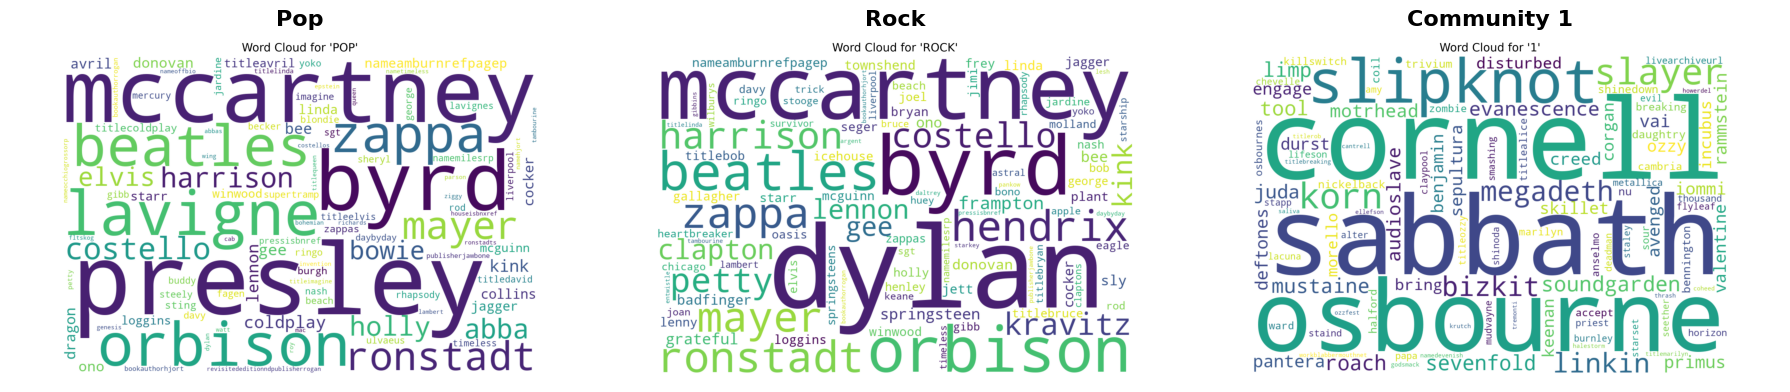

In [210]:
# image paths 
img1 = Path("wordclouds_all_genres/POP_wordcloud.png")     
img2 = Path("wordclouds_all_genres/ROCK_wordcloud.png")    
img3 = Path("wordclouds_louvain/1_wordcloud.png")      

titles = ["Pop", "Rock", "Community 1"]

# Plot them side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, img_path, title in zip(axes, [img1, img2, img3], titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title, fontsize=16, weight="bold")

plt.tight_layout()
plt.show()

Even though there is a strong presence of the Pop and Rock genres in Community 1 as was shown in Part 2 (26% and 41%, respectively) we can that the the words that more ind

- Community 2 & Heavy Metal and Hard Rock

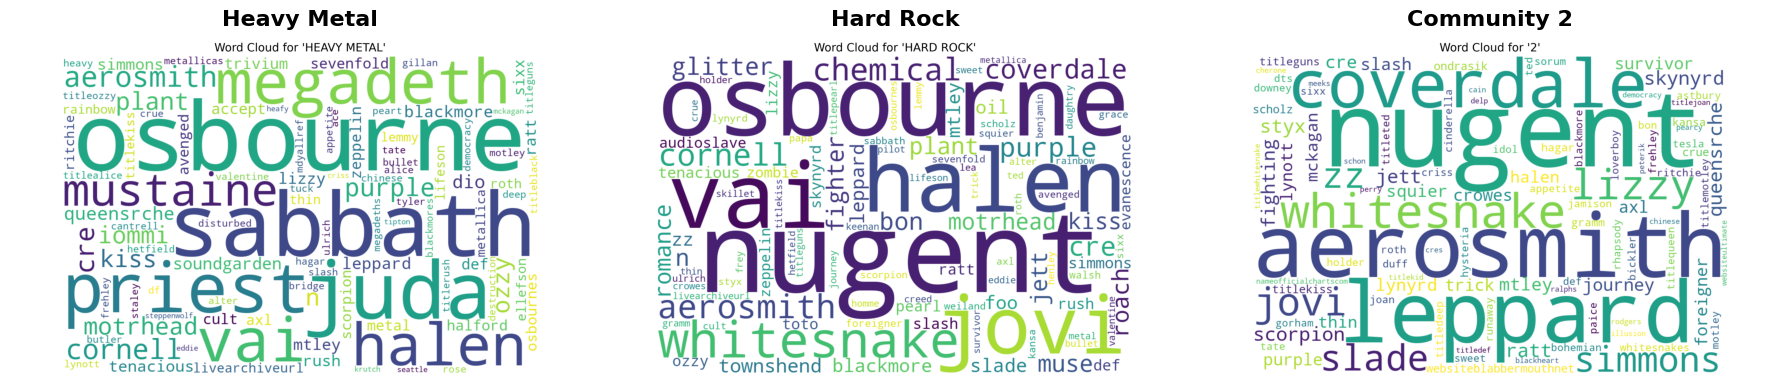

In [211]:
# image paths 
img1 = Path("wordclouds_all_genres/HEAVY METAL_wordcloud.png")     
img2 = Path("wordclouds_all_genres/HARD ROCK_wordcloud.png")    
img3 = Path("wordclouds_louvain/2_wordcloud.png")      

titles = ["Heavy Metal", "Hard Rock", "Community 2"]

# Plot them side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, img_path, title in zip(axes, [img1, img2, img3], titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title, fontsize=16, weight="bold")

plt.tight_layout()
plt.show()

In this Figure we can observe the word-clouds for the heavy metal and hard rock genres and community 2. The predominant genre in community 2 is hard rock, as can be seen in the matrix of Part 2. This overlap can be seen in the word-clouds as words like Nugent and Whitesnake are present in both diagrams.

- Community 3 & Alternative Rock, Alternative Metal and Hard Rock

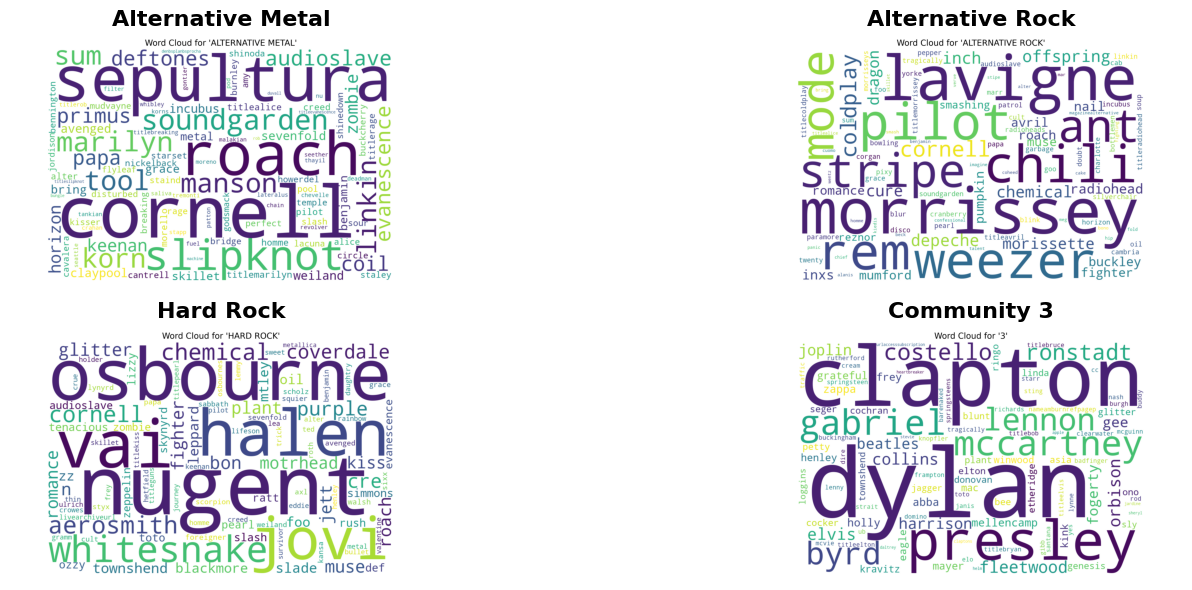

In [213]:
# image paths 
img1 = Path("wordclouds_all_genres/ALTERNATIVE METAL_wordcloud.png")     
img2 = Path("wordclouds_all_genres/ALTERNATIVE ROCK_wordcloud.png") 
img3 = Path("wordclouds_all_genres/HARD ROCK_wordcloud.png")   
img4 = Path("wordclouds_louvain/3_wordcloud.png")      

titles = ["Alternative Metal", "Alternative Rock", "Hard Rock", "Community 3"]

# Plot them side by side
fig, axes = plt.subplots(2, 2, figsize=(18, 6))
axes = axes.ravel()

for ax, img_path, title in zip(axes, [img1, img2, img3, img4], titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title, fontsize=16, weight="bold")

plt.tight_layout()
plt.show()

- Community 4 & Alternative Rock and Pop Rock

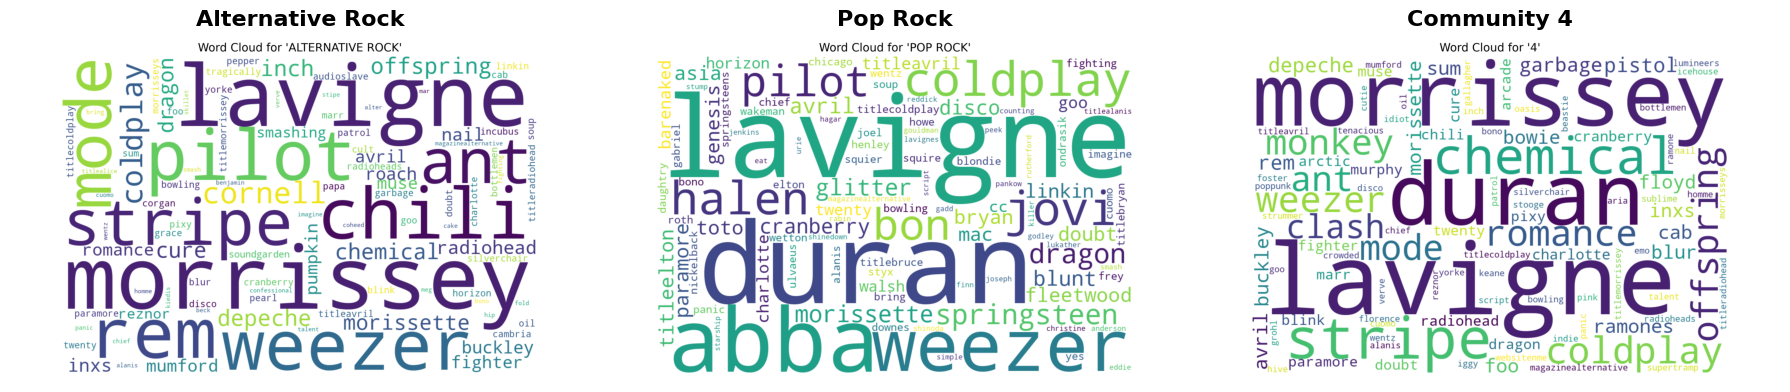

In [217]:
# image paths 
img1 = Path("wordclouds_all_genres/ALTERNATIVE ROCK_wordcloud.png")     
img2 = Path("wordclouds_all_genres/POP ROCK_wordcloud.png")    
img3 = Path("wordclouds_louvain/4_wordcloud.png")      

titles = ["Alternative Rock", "Pop Rock", "Community 4"]

# Plot them side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, img_path, title in zip(axes, [img1, img2, img3], titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title, fontsize=16, weight="bold")

plt.tight_layout()
plt.show()

In this Figure we can observe the word-clouds for the pop rock  and alternative rock genres and community 4. Community 4 is composed by 52% of artists belonging to alternative rock genre and 28% of artists belonging to the pop rock one. However, by looking at the word-clouds we can see that there is a significant overlap between the significant words for the community in question and the pop rock genre, with Lavigne and Duran being 2 of the most relevant words for both of them. This aligns well with the TF-IDF results we obtained before.